In [1]:
import math
import random
import numpy as np
from itertools import product

from qiskit import *

# Importing standard Qiskit libraries
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.aer import QasmSimulator

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

from qiskit.utils import QuantumInstance

from qiskit.opflow import I, X, Y, Z
from qiskit.opflow import StateFn
from qiskit.opflow import Gradient
from qiskit.opflow import CircuitSampler
from qiskit.opflow.primitive_ops import MatrixOp

from qiskit.circuit import Parameter
from qiskit.circuit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import RealAmplitudes

from qiskit.algorithms.optimizers import SPSA
from qiskit.algorithms.optimizers import GradientDescent
from qiskit.algorithms.optimizers import ADAM

from qiskit.extensions.unitary import UnitaryGate
from qiskit.circuit.library.standard_gates import CHGate
from qiskit.circuit.library.standard_gates import RZGate

from qiskit.providers.aer.noise import NoiseModel

from qiskit.quantum_info import Statevector
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter

In [2]:
provider = IBMQ.load_account()

In [3]:
def rand_numb(low_in,high_in):
    '''
    Returns a random number between low_in and high_in, including both end points.
    '''
    return np.random.uniform(low=low_in, high=np.nextafter(high_in, np.inf))

In [4]:
'''
Define variables for the number of layers and qubits of the prover. Define global variables used in the optimization.
'''
numLayer = 3
numQubit = 3
global iterations
global noisy

In [5]:
def createEqSuperposCollectiveZ():
    '''
    Defines a quantum circuit to create the uniform superposition of basis elements required.
    '''
    temp = QuantumCircuit(2)
    temp.ry(2*np.arctan(np.sqrt(2)), 1)
    temp.ch(1, 0)
    return temp

In [6]:
def createProver(numQubit, numLayer):
    '''
    Creates a parameterized unitary on numQubit qubits. Applies numLayer layers of the HEA with 2 Qiskit.parameters 
    per qubit per layer, specifying rotations about the x- and y-axes. After each layer, applies a neighbouring qubit
    CNOT layer. Returns a QuantumCircuit object containing the parameterized prover. 
    '''
    numparam = numQubit*numLayer*2
    prover = QuantumCircuit(numQubit)
    param_vector = ParameterVector("params", numparam)
    
    for j in range(numLayer):
        for i in range(numQubit):
            prover.rx(param_vector[j*2*numQubit + i], i)
            prover.ry(param_vector[j*2*numQubit + i + numQubit], i)

        for i in range(numQubit-1):
            prover.cx(i, i+1)
            
    return prover

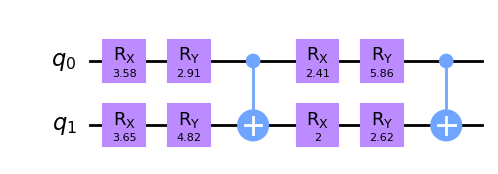

In [7]:
'''
Defines parameters that specify the purification of state to be tested. Create a QuantumCircuit object that
creates the purification on (size) number of qubits.
'''
unitary_param_1 = np.array([])
size = 2
layers = 2
for i in range(0, 2*size*layers):
    unitary_param_1 = np.append(unitary_param_1, np.array([rand_numb(0,2*np.pi)]))

state = QuantumCircuit(size)
for j in range(layers):
    for i in range(size):
        state.rx(unitary_param_1[j*size*2 + i], i)
        state.ry(unitary_param_1[j*2*size + i + size], i)

    for i in range(size-1):
        state.cx(i, i+1)

state.draw('mpl')

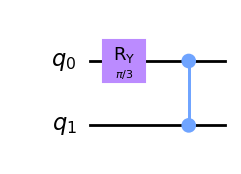

In [34]:
state = QuantumCircuit(2)
state.ry(np.pi/3, 0)
state.cz(0, 1)
state.draw('mpl')

In [35]:
'''
Define U_0 gate from Appendix G
'''
U0 = QuantumCircuit(2)
U0.append(RZGate(-2*np.pi/3), [0])
U0.append(RZGate(-2*np.pi/3), [1])

U2 = QuantumCircuit(2)
U2.append(RZGate(2*np.pi/3), [0])
U2.append(RZGate(2*np.pi/3), [1])

In [36]:
def createQuantumCircuit(state, numQubit, numLayer):
    '''
    Creates quantum circuit for the problem. 
    Refer to Appendix G from https://arxiv.org/pdf/2105.12758
    The ciruit contains 6 qubits each labelled as (C, S, S', E)
    '''
    circ = QuantumCircuit(6)
    
    superPosCircuit = createEqSuperposCollectiveZ()
    circ.append(superPosCircuit, [0, 1])

    circ.append(state, [2, 3])
    
    prover = createProver(numQubit, numLayer)
    circ.append(prover, [3, 4, 5])
    
    circ.barrier()
    
    controlledU0 = U0.to_gate().control(1)
    controlledU2 = U2.to_gate().control(1)
    
    circ.append(controlledU0, [1, 2, 3])
    circ.append(controlledU2, [1, 4, 5])
    
    circ.append(controlledU0, [0, 2, 3])
    circ.append(controlledU2, [0, 4, 5])
    
    circ.append(superPosCircuit.inverse(), [0, 1])
    
    return circ

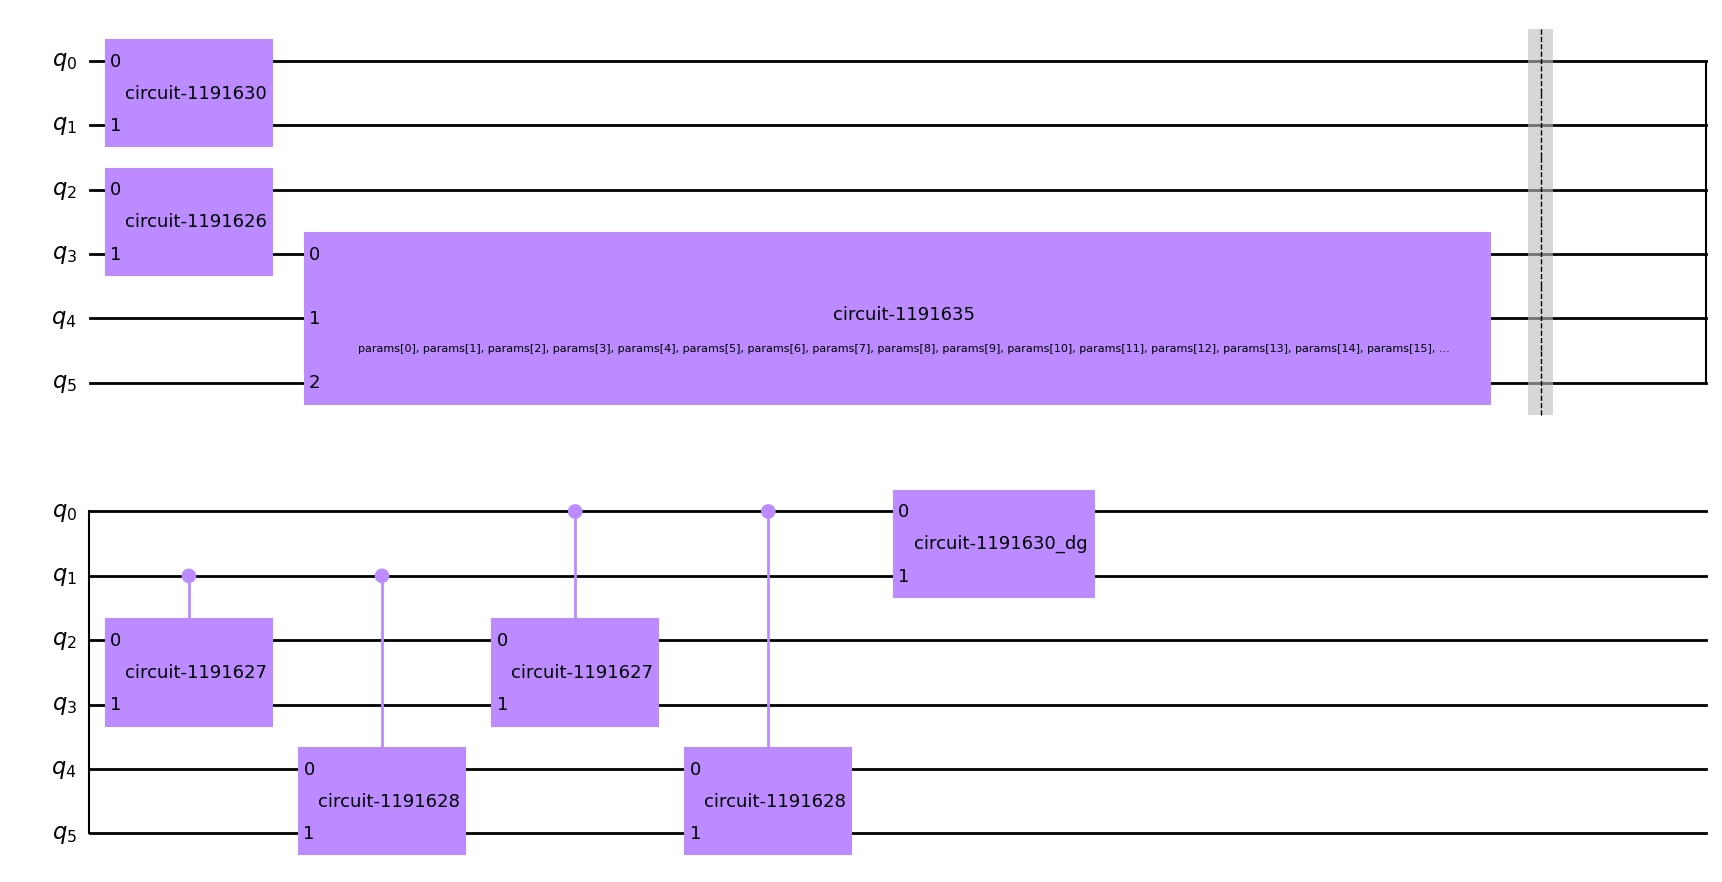

In [37]:
'''
Creates the quantum circuit
'''
qCirc = createQuantumCircuit(state, numQubit, numLayer)
qCirc.draw('mpl')

In [38]:
'''
List of parameters of the quantum circuit.
'''
print(qCirc.parameters)

ParameterView([ParameterVectorElement(params[0]), ParameterVectorElement(params[1]), ParameterVectorElement(params[2]), ParameterVectorElement(params[3]), ParameterVectorElement(params[4]), ParameterVectorElement(params[5]), ParameterVectorElement(params[6]), ParameterVectorElement(params[7]), ParameterVectorElement(params[8]), ParameterVectorElement(params[9]), ParameterVectorElement(params[10]), ParameterVectorElement(params[11]), ParameterVectorElement(params[12]), ParameterVectorElement(params[13]), ParameterVectorElement(params[14]), ParameterVectorElement(params[15]), ParameterVectorElement(params[16]), ParameterVectorElement(params[17])])


In [39]:
'''
Pick a backend to use. We use the statevector_simulator for noiseless simulation.
'''
noiseless_backend = Aer.get_backend('statevector_simulator')
noiseless_q_instance = QuantumInstance(noiseless_backend)
noiseless_sampler = CircuitSampler(noiseless_q_instance)

In [40]:
'''
Pick a backend to use. We use the qasm_simulator for noisy simulation.
'''
provider = IBMQ.get_provider(hub="ibm-q-research", group="louisiana-st-uni-1", project="main")
noisy_backend = Aer.get_backend("qasm_simulator")
device = provider.get_backend("ibm_lagos")
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device.properties())
noisy_q_instance = QuantumInstance(backend=noisy_backend, 
                           shots=8192, 
                           noise_model=noise_model, 
                           coupling_map=coupling_map,
                           measurement_error_mitigation_cls=CompleteMeasFitter,
                           cals_matrix_refresh_period=30)
noisy_sampler = CircuitSampler(noisy_q_instance)

<ipython-input-40-634570ecb369>:8: DeprecationWarning: Passing BackendProperties instead of a "backend" object has been deprecated as of qiskit-aer 0.10.0 and will be removed no earlier than 3 months from that release date. Duration dependent delay relaxation noise requires a backend object.
  noise_model = NoiseModel.from_backend(device.properties())


In [41]:
def costf(params):
    '''
    Assigns the params input to the parameters of the ansatz, and calculates the expectation value.
    '''
    expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qCirc))
    value_dict = dict(zip(qCirc.parameters, params))
    
    if noisy:
        result = noisy_sampler.convert(expectation, params=value_dict).eval()  
    else:
        result = noiseless_sampler.convert(expectation, params=value_dict).eval()  
    
    return -1*np.real(result)

In [42]:
def gradient(params):
    '''
    Assigns the params input to the parameters of the ansatz, and calculates the gradient value.
    '''
    expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qCirc))
    value_dict = dict(zip(qCirc.parameters, params))
    gradient = Gradient().convert(expectation)
    
    if noisy:
        result = noisy_sampler.convert(gradient, params=value_dict).eval()  
    else:
        result = noiseless_sampler.convert(gradient, params=value_dict).eval()  
    
    return -1*np.real(result)

In [43]:
def autospsa_callback(nfev, x, fx, stepsize, accepted = False):
    '''
    Callback function called automatically during optimization. Appends loss value, current iteration and 
    prints every iteration with a completion percentage.
    '''
    if (noisy == True):
        noisy_loss.append(-1*fx)
    else:
        noiseless_loss.append(-1*fx)
    print("Loss Value : ", -1*fx, str(nfev/3)+"%")

In [44]:
'''
Average value of this hamiltonian is the probability of measuring 0 on the first two qubits.
MatrixOp(np.array([[1, 0], [0, 0])) is the projector on the 0 subspace. Qiskit orders qubits in reverse.
'''
hamiltonian = I^I^I^I^MatrixOp(np.array([[1, 0], [0, 0]]))^MatrixOp(np.array([[1, 0], [0, 0]]))

In [45]:
'''
Initialize prover parameters to random angles
'''
numParam = 2*numQubit*numLayer
noisy = False
paramProver = []
for i in range(0, numParam):
    paramProver = np.append(paramProver, np.array([rand_numb(0,2*np.pi)]))
print(paramProver)

print("Initial Cost : ", -1*costf(paramProver))

[2.38141674 4.6237792  5.04025821 0.43346144 2.45908757 4.45237961
 1.45117665 3.73163786 1.36056531 3.98957255 0.39147165 2.23844853
 2.18933358 1.3425786  6.14326708 0.39714218 1.21823729 2.00657662]
Initial Cost :  0.4751593066008


In [46]:
'''
True value calculated using the SDP.
'''
true_value = 0.7500033472009535

In [47]:
'''
Perform the noiseless optimization using the SPSA algorithm for 200 iterations.
'''
noisy = False
noiseless_loss = []
noiselessParam = np.copy(paramProver)
print("Initial Cost : ", -1*costf(noiselessParam))
autospsa = SPSA(maxiter=200, learning_rate=None, perturbation=None, callback=autospsa_callback)
x_opt, fx_opt, nfevs = autospsa.optimize(numParam, costf, initial_point=noiselessParam)

Initial Cost :  0.4751593066008


<ipython-input-47-138481431eb0>:9: DeprecationWarning: The SPSA.optimize method is deprecated as of Qiskit Terra 0.21.0 and will be removed no sooner than 3 months after the release date. Instead, use SPSA.minimize as a replacement, which supports the same arguments but follows the interface of scipy.optimize and returns a complete result object containing additional information.
  x_opt, fx_opt, nfevs = autospsa.optimize(numParam, costf, initial_point=noiselessParam)


Loss Value :  0.4865596265957183 1.0%
Loss Value :  0.29171068297920455 2.0%
Loss Value :  0.30681648341005807 3.0%
Loss Value :  0.4918877522756379 4.0%
Loss Value :  0.5552819771929232 5.0%
Loss Value :  0.5896075677089725 6.0%
Loss Value :  0.5896031435406673 7.0%
Loss Value :  0.5910161216461609 8.0%
Loss Value :  0.6083825203891138 9.0%
Loss Value :  0.6149063688324141 10.0%
Loss Value :  0.6149239492681682 11.0%
Loss Value :  0.6167956412872909 12.0%
Loss Value :  0.6191662242403111 13.0%
Loss Value :  0.6201369259016742 14.0%
Loss Value :  0.6608902435063411 15.0%
Loss Value :  0.661188619655425 16.0%
Loss Value :  0.6650641929228821 17.0%
Loss Value :  0.6682061772462419 18.0%
Loss Value :  0.6824457722709999 19.0%
Loss Value :  0.6905654376578851 20.0%
Loss Value :  0.6912433967903122 21.0%
Loss Value :  0.6941300531073346 22.0%
Loss Value :  0.6945148021139074 23.0%
Loss Value :  0.6978874151853138 24.0%
Loss Value :  0.7101003390634892 25.0%
Loss Value :  0.7138842707240556 

In [48]:
'''
Perform the noisy optimization using the SPSA algorithm for 200 iterations.
'''
noisy = True
noisy_loss = []
noisyParam = np.copy(paramProver)
-1*costf(noisyParam)
print("Initial Cost : ", -1*costf(noisyParam))
autospsa = SPSA(maxiter=200, learning_rate=None, perturbation=None, callback=autospsa_callback)
x_opt, fx_opt, nfevs = autospsa.optimize(numParam, costf, initial_point=noisyParam)

Initial Cost :  0.442138671875


<ipython-input-48-8a2498bb173e>:10: DeprecationWarning: The SPSA.optimize method is deprecated as of Qiskit Terra 0.21.0 and will be removed no sooner than 3 months after the release date. Instead, use SPSA.minimize as a replacement, which supports the same arguments but follows the interface of scipy.optimize and returns a complete result object containing additional information.
  x_opt, fx_opt, nfevs = autospsa.optimize(numParam, costf, initial_point=noisyParam)


Loss Value :  0.40393066406249994 1.0%
Loss Value :  0.39294433593750006 2.0%
Loss Value :  0.48767089843750006 3.0%
Loss Value :  0.48107910156250006 4.0%
Loss Value :  0.4521484375 5.0%
Loss Value :  0.49414062499999994 6.0%
Loss Value :  0.50634765625 7.0%
Loss Value :  0.5184326171875 8.0%
Loss Value :  0.525390625 9.0%
Loss Value :  0.5322265625 10.0%
Loss Value :  0.5628662109375 11.0%
Loss Value :  0.56884765625 12.0%
Loss Value :  0.5791015625 13.0%
Loss Value :  0.5689697265625 14.0%
Loss Value :  0.5826416015625 15.0%
Loss Value :  0.6124267578125 16.0%
Loss Value :  0.6370849609375 17.0%
Loss Value :  0.6365966796875 18.0%
Loss Value :  0.634765625 19.0%
Loss Value :  0.6378173828125 20.0%
Loss Value :  0.6267089843750001 21.0%
Loss Value :  0.6335449218750001 22.0%
Loss Value :  0.6444091796875 23.0%
Loss Value :  0.6361083984375 24.0%
Loss Value :  0.6300048828125 25.0%
Loss Value :  0.6520996093750001 26.0%
Loss Value :  0.6442871093750001 27.0%
Loss Value :  0.6434326171

In [49]:
'''
Evaluate the noiseless cost function using the parameters learned from the noisy optimization. 
'''
noisy = False
noiseResilientValue = -1*costf(x_opt)
print(noiseResilientValue)

0.7484342088421959


In [50]:
'''
Print all final values after training.
'''
print("True Value : ", true_value)
print("Noiseless : ", noiseless_loss[-1])
print("Noisy : ", noisy_loss[-1])
print("Noise Resilient Value : ", noiseResilientValue)

True Value :  0.7500033472009535
Noiseless :  0.7494376788252961
Noisy :  0.65771484375
Noise Resilient Value :  0.7484342088421959


In [32]:
def writeToFile():
    '''
    Write the training data to a text file to be used to plot the data. The format is as follows:
        True Value
        Noise Resilient Value
        Size of noiseless data list
        [
        Noiseless data with one entry per line
        ]
        Size of noisy data list
        [
        Noisy data with one entry per line
        ]
    '''
    file = open("CZ_GSE.txt", "w+")
    file.write(str(true_value)+"\n")
    file.write(str(noiseResilientValue)+"\n")

    file.write(str(len(noiseless_loss))+"\n")
    L = [str(i)+"\n" for i in noiseless_loss]
    file.writelines(L)
    
    file.write(str(len(noisy_loss))+"\n")
    L = [str(i)+"\n" for i in noisy_loss[0:len(noisy_loss)-1]]
    file.writelines(L)
    
    file.write(str(noisy_loss[-1]))
    
    file.close()

In [33]:
writeToFile()